Battery Life Prediction using Deep Learning

This script implements a deep learning model for predicting battery remaining useful life (RUL)
using a combination of CNNs and RNNs. It processes both simulation and experimental data
to train and evaluate the model.

Key Features:
- Depthwise separable convolution for feature extraction
- GRU-based recurrent networks for temporal modeling
- Multi-modal data fusion (simulation + experimental)

Date: 2025

In [1]:
import os

import matplotlib.pyplot as plt
import numpy
import scipy.io
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn import init
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch

use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def test_accuracy_cal(predictions, test_label):
    """
 Calculate comprehensive test accuracy metrics for battery life prediction

 Args:
     predictions (torch.Tensor): Predicted RUL values
     test_label (torch.Tensor): True RUL values

 Returns:
     tuple: RMSE, MAE, MAPE, R2 metrics as numpy arrays
 """
    # Root Mean Square Error
    test_rmse = torch.sqrt(torch.mean(torch.square(predictions - test_label)))

    # Mean Absolute Error
    test_mae = torch.mean(torch.abs(predictions - test_label))

    # Mean Absolute Percentage Error
    test_mape = torch.mean(torch.abs(predictions - test_label) / test_label)

    # Mean Square Error for R2 calculation
    mse = torch.mean(torch.square(predictions - test_label))

    # R-squared coefficient
    test_r2 = 1 - mse / torch.var(predictions)


    return (test_rmse.cpu().detach().numpy(),
            test_mae.cpu().detach().numpy(),
            test_mape.cpu().detach().numpy(),
            test_r2.cpu().detach().numpy())


def moving_average(data, n=3):
    """
 Apply moving average smoothing to time series data

 Args:
     data (numpy.array): Input time series data
     n (int): Window size for moving average

 Returns:
     numpy.array: Smoothed data
 """
    data_output = numpy.copy(data)
    for i in range(len(data)):
        if i + n < len(data):
            data_output[i + n] = numpy.sum(data[i:i + n], axis=0) / n
    return data_output




In [ ]:
# Calibration Cycle life
Cyclelife_1 = [1217, 1247, 1234, 1223, 843, 1085, 1135, 687, 616, 862, 197, 297, 398, 385, 602, 197, 303, 107, 66, 49, 119]
Cyclelife_2 = [1183, 1650, 1846, 1515, 854, 1224, 652, 816, 966, 798, 256, 189, 568, 509, 493, 119, 317, 64, 154, 59, 130]
Cyclelife_3 = [1291, 887, 1244, 1124, 551, 1524, 934, 572, 521, 616, 253, 234, 343, 479, 523, 198, 465, 115, 89, 47, 116]
Cyclelife_4 = [1648, 841, 1616, 1332, 667, 1221, 605, 719, 526, 704, 456, 364, 314, 425, 517, 104, 247, 252, 65, 111, 127]

In [37]:
Cyclelife_1 = numpy.array(Cyclelife_1).reshape(-1,1)
Cyclelife_2 = numpy.array(Cyclelife_2).reshape(-1,1)
Cyclelife_3 = numpy.array(Cyclelife_3).reshape(-1,1)
Cyclelife_4 = numpy.array(Cyclelife_4).reshape(-1,1)
Cyclelife_all = numpy.concatenate((Cyclelife_1, Cyclelife_2, Cyclelife_3, Cyclelife_4), axis=1)

In [38]:
def extract_feature(batch_name, battery_number, data_simulation, data_CM):
    
    data_all = data_simulation

    Cyclelife = data_all[batch_name][0, battery_number][0][0][0][3][0,0]

    discharge_t = []
    discharge_v = []
    discharge_tb = []
    discharge_Vo = []
    discharge_Vsn = []
    discharge_Vsp = []
    discharge_qnB = []
    discharge_qnS = []
    discharge_qpB = []
    discharge_qpS = []
    discharge_qMax = []
    discharge_Ro = []
    discharge_D = []
    
    for i in range(len(data_all[batch_name][0, battery_number][2][0])):
        discharge_t.append(data_all[batch_name][0, battery_number][2][0][i][0])
        discharge_v.append(data_all[batch_name][0, battery_number][2][0][i][1])
        discharge_tb.append(data_all[batch_name][0, battery_number][2][0][i][2])
        discharge_Vo.append(data_all[batch_name][0, battery_number][2][0][i][3])
        discharge_Vsn.append(data_all[batch_name][0, battery_number][2][0][i][4])
        discharge_Vsp.append(data_all[batch_name][0, battery_number][2][0][i][5])
        discharge_qnB.append(data_all[batch_name][0, battery_number][2][0][i][6])
        discharge_qnS.append(data_all[batch_name][0, battery_number][2][0][i][7])
        discharge_qpB.append(data_all[batch_name][0, battery_number][2][0][i][8])
        discharge_qpS.append(data_all[batch_name][0, battery_number][2][0][i][9])
        discharge_qMax.append(data_all[batch_name][0, battery_number][2][0][i][10])
        discharge_Ro.append(data_all[batch_name][0, battery_number][2][0][i][11])
        discharge_D.append(data_all[batch_name][0, battery_number][2][0][i][12])

    discharge_t = numpy.array(discharge_t)
    discharge_v = numpy.array(discharge_v)
    discharge_tb = numpy.array(discharge_tb)
    discharge_Vo = numpy.array(discharge_Vo)
    discharge_Vsn = numpy.array(discharge_Vsn)
    discharge_Vsp = numpy.array(discharge_Vsp)
    discharge_qnB = numpy.array(discharge_qnB)
    discharge_qnS = numpy.array(discharge_qnS)
    discharge_qpB = numpy.array(discharge_qpB)
    discharge_qpS = numpy.array(discharge_qpS)
    discharge_qMax = numpy.array(discharge_qMax)
    discharge_Ro = numpy.array(discharge_Ro)
    discharge_D = numpy.array(discharge_D)

    window_len = 3
    
    discharge_t = moving_average(discharge_t, n=window_len)
    discharge_v = moving_average(discharge_v, n=window_len)
    discharge_tb = moving_average(discharge_tb, n=window_len)
    discharge_Vo = moving_average(discharge_Vo, n=window_len)
    discharge_Vsn = moving_average(discharge_Vsn, n=window_len)
    discharge_Vsp = moving_average(discharge_Vsp, n=window_len)
    discharge_qnB = moving_average(discharge_qnB, n=window_len)
    discharge_qnS = moving_average(discharge_qnS, n=window_len)
    discharge_qpB = moving_average(discharge_qpB, n=window_len)
    discharge_qpS = moving_average(discharge_qpS, n=window_len)
    discharge_qMax = moving_average(discharge_qMax, n=window_len)
    discharge_Ro = moving_average(discharge_Ro, n=window_len)
    discharge_D = moving_average(discharge_D, n=window_len)

    data_all = data_CM
    
    charge_V = data_all[batch_name][0, battery_number][0][0][0][0]
    charge_I = data_all[batch_name][0, battery_number][0][0][0][1]
    charge_Q = data_all[batch_name][0, battery_number][0][0][0][2]
    charge_T = data_all[batch_name][0, battery_number][0][0][0][3]
    charge_E = data_all[batch_name][0, battery_number][0][0][0][4]
    charge_dQdV = data_all[batch_name][0, battery_number][0][0][0][5]
    charge_t_s = data_all[batch_name][0, battery_number][0][0][0][6]
    discharge_V = data_all[batch_name][0, battery_number][0][0][0][7]
    discharge_I = data_all[batch_name][0, battery_number][0][0][0][8]
    discharge_Q = data_all[batch_name][0, battery_number][0][0][0][9]
    discharge_T = data_all[batch_name][0, battery_number][0][0][0][10]
    discharge_E = data_all[batch_name][0, battery_number][0][0][0][11]
    discharge_dQdV = data_all[batch_name][0, battery_number][0][0][0][12]
    discharge_t_s = data_all[batch_name][0, battery_number][0][0][0][13]
    
    Cyclelife = min(Cyclelife, Cyclelife_all[int(batch_name[-2:])-1, battery_number])

    RUL = numpy.arange(Cyclelife, 0, -1).reshape(-1, 1) * 1.0

    discharge_feature_VIT = numpy.concatenate((discharge_V[:, None, :], discharge_Q[:, None, :], discharge_E[:, None, :], 
                                               discharge_T[:, None, :], discharge_dQdV[:, None, :], discharge_t_s[:, None, :]), axis=1)

    discharge_feature_Simulation = numpy.concatenate((discharge_Vo, discharge_Vsn, discharge_Vsp, 
                                                      discharge_qnS, discharge_qnB, discharge_qpB, 
                                                      discharge_qpS, discharge_Ro, discharge_D), axis=1)

    
    discharge_feature_VIT2 = discharge_feature_VIT[0:Cyclelife] - discharge_feature_VIT[0,:]
    discharge_feature_Simulation2 = discharge_feature_Simulation[0:Cyclelife] - discharge_feature_Simulation[0,:]
    
    discharge_feature_VIT_all = numpy.concatenate((discharge_feature_VIT[1:Cyclelife, :], discharge_feature_VIT2[1:Cyclelife, :]), axis=1)
    discharge_feature_Simulation_all = numpy.concatenate((discharge_feature_Simulation[1:Cyclelife, :], discharge_feature_Simulation2[1:Cyclelife, :]), axis=1)

    return discharge_feature_VIT_all[0:Cyclelife], discharge_feature_Simulation_all[0:Cyclelife], RUL[1:Cyclelife]
    

In [6]:

def weighted_moving_average(data, window_size):
    weights = numpy.arange(1, window_size + 1) * 1.0
    weights = weights / numpy.sum(weights)
    smoothed_data = numpy.convolve(data.reshape(-1, ), weights, mode='same')
    data_sum = 0
    for i in range(window_size):
        data_sum = data_sum + data[i]
        smoothed_data[i] = data_sum / (i + 1)
    return smoothed_data

In [7]:
class DepthwiseSeparableConvolution(nn.Module):
    """
     Depthwise Separable Convolution layer for efficient feature extraction
    
     This reduces computational cost while maintaining representational power
     by factorizing standard convolution into depthwise and pointwise operations.
     """

    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1):
        super().__init__()

        # Depthwise convolution: applies one filter per input channel
        self.depthwise_conv = nn.Conv2d(
            in_channels=in_ch,
            out_channels=in_ch,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=in_ch  # Key: number of groups equals input channels
        )

        # Pointwise convolution: 1x1 conv to combine features across channels
        self.pointwise_conv = nn.Conv2d(
            in_channels=in_ch,
            out_channels=out_ch,
            kernel_size=1,
            stride=1,
            padding=0,
            groups=1
        )

    def forward(self, x):
        out = self.depthwise_conv(x)
        out = self.pointwise_conv(out)
        return out


class Net(nn.Module):
    """
     Hybrid CNN-RNN Neural Network for Battery Life Prediction
    
     Architecture:
     - Depthwise separable convolutions for spatial feature extraction
     - GRU for temporal sequence modeling
     - Fully connected layers for final RUL prediction
     """

    def __init__(self,input_channels=2,image_size=100, life_linear=1000):
        """
          Initialize the neural network
        
          Args:
              input_channels (int): Number of input feature channels
              image_size (int): Size of input feature maps
              life_linear (int): Input size for final linear layers
        """
        super(Net, self).__init__()
        
        # Convolutional feature extraction layers
        self.DepthwiseSeparableConvolution1 = DepthwiseSeparableConvolution(input_channels, 64)
        self.DepthwiseSeparableConvolution2 = DepthwiseSeparableConvolution(64, 32)
        self.DepthwiseSeparableConvolution3 = DepthwiseSeparableConvolution(32, 16)
        self.DepthwiseSeparableConvolution4 = DepthwiseSeparableConvolution(16, 8)
        
        # Recurrent layers for temporal modeling
        self.rnn1 = nn.GRU(50, 200, batch_first=True)
        self.rnn2 = nn.GRU(200, 300, batch_first=True)
    
        # Pooling layer for dimensionality reduction
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # Final prediction layers
        self.life = nn.Sequential(
            nn.Linear(life_linear, 600),
            nn.ReLU(),
            nn.Linear(600, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.ReLU(),)

    def forward(self, x1, x2):
        """
        Forward pass through the network

        Args:
            x (torch.Tensor): Input tensor with shape (batch, channels, height, width)

        Returns:
            torch.Tensor: Predicted RUL values
        """
        # CNN pathway for spatial features
        out = self.pool(self.DepthwiseSeparableConvolution1(x2))
        out = self.pool(self.DepthwiseSeparableConvolution2(out))
        out = self.DepthwiseSeparableConvolution3(out)
        out = out.view(-1, self.num_flat_features(out))
        
        # RNN pathway for temporal features
        out_GRU, _ = self.rnn1(x1.squeeze(1))
        out_GRU = out_GRU[:,-1]
        
        # Fusion of CNN and RNN features
        out = torch.cat((out, out_GRU), dim=1)
    
        # Final prediction
        out = self.life(out)
        return out

    def num_flat_features(self, x):
        """Calculate number of features after flattening"""
        size = x.size()[1:]  # All dimensions except batch
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def initialize_weights(self):
        """Initialize network weights using Xavier/He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                torch.nn.init.normal_(m.weight.data, 0, 0.01)
                m.bias.data.zero_()


In [8]:

data_simulation = scipy.io.loadmat(r'../../SimulationData_RetiredBattery.mat')['SimulationData_RetiredBattery'][0, 0]

data_CM = scipy.io.loadmat(r'../../RetiredBatteryData_all.mat')['RetiredBatteryData_all'][0, 0]
# 'batch18', 'batch19', 'batch20',
batch_list = [ 'batch01', 'batch02','batch03','batch04','batch05','batch06','batch07',\
              'batch08','batch09','batch10','batch11','batch12','batch13','batch14',\
            'batch15','batch16','batch17','batch18','batch19','batch20', 'batch21']

In [39]:
batch_list = [ 'batch03','batch04','batch05','batch06',\
              'batch09','batch10','batch13','batch14','batch15','batch17']

train_discharge_feature = numpy.array([])
train_label1 = numpy.array([])
copy_number = 0

for batch_name in batch_list:
    battery_all = [1, 2, 3]
    for battery_num in battery_all:
        discharge_feature_VIT, discharge_feature_sim, RUL = extract_feature(batch_name, battery_num, data_simulation, data_CM)
        for i in range(copy_number+1):
            try:
                train_discharge_feature1 = numpy.concatenate((train_discharge_feature1, discharge_feature_VIT), axis=0)
                train_discharge_feature2 = numpy.concatenate((train_discharge_feature2, discharge_feature_sim), axis=0)
                train_label1 = numpy.concatenate((train_label1, RUL), axis=0)
            except:
                train_discharge_feature1 = discharge_feature_VIT
                train_discharge_feature2 = discharge_feature_sim
                train_label1 = RUL

print(train_discharge_feature1.shape)
print(train_discharge_feature2.shape)
print(train_label1.shape)

test_discharge_feature = numpy.array([])
test_label = numpy.array([])
test_index = [0]

for batch_name in batch_list:
    battery_all = [0]
    for battery_num in battery_all:
        discharge_feature_VIT, discharge_feature_sim, RUL = extract_feature(batch_name, battery_num, data_simulation, data_CM)
        try:
            test_discharge_feature1 = numpy.concatenate((test_discharge_feature1, discharge_feature_VIT), axis=0)
            test_discharge_feature2 = numpy.concatenate((test_discharge_feature2, discharge_feature_sim), axis=0)
            test_label = numpy.concatenate((test_label, RUL), axis=0)
        except:
            test_discharge_feature1 = discharge_feature_VIT
            test_discharge_feature2 = discharge_feature_sim
            test_label = RUL
            test_index.append(len(test_discharge_feature1))
print(test_discharge_feature1.shape)
print(test_discharge_feature2.shape)
print(test_label.shape)

(23968, 12, 100)
(23968, 18, 100)
(23968, 1)
(7504, 12, 100)
(7504, 18, 100)
(7504, 1)


In [40]:
# Norm
max_discharge_feature1 = numpy.max(train_discharge_feature1, axis=2).max(0)[None, :, None]
min_discharge_feature1 = numpy.min(train_discharge_feature1, axis=2).min(0)[None, :, None]
train_discharge_feature1 = 2 * (train_discharge_feature1 - min_discharge_feature1) / (
        max_discharge_feature1 - min_discharge_feature1) - 1

max_discharge_feature2 = numpy.max(train_discharge_feature2, axis=2).max(0)[None, :, None]
min_discharge_feature2 = numpy.min(train_discharge_feature2, axis=2).min(0)[None, :, None]
train_discharge_feature2 = 2 * (train_discharge_feature2 - min_discharge_feature2) / (
        max_discharge_feature2 - min_discharge_feature2) - 1


test_discharge_feature1 = 2 * (test_discharge_feature1 - min_discharge_feature1) / (
        max_discharge_feature1 - min_discharge_feature1) - 1
test_discharge_feature2 = 2 * (test_discharge_feature2 - min_discharge_feature2) / (
        max_discharge_feature2 - min_discharge_feature2) - 1

test_discharge_feature1[numpy.where(test_discharge_feature1 > 1)] = 1
test_discharge_feature1[numpy.where(test_discharge_feature1 < -1)] = -1
test_discharge_feature2[numpy.where(test_discharge_feature2 > 1)] = 1
test_discharge_feature2[numpy.where(test_discharge_feature2 < -1)] = -1


In [63]:
import gc
'''
    Training model
'''

batch_size = 128*64
lr = 0.0005
drop_rate = 0.0003
epochs = 5000

interval = 2
# training dataset1
train_x1 = torch.tensor(train_discharge_feature1[:,None,:,::interval], dtype=torch.float32)
train_x2 = torch.tensor(train_discharge_feature2[:,None,:,::interval], dtype=torch.float32)
train_y1 = torch.tensor(train_label1, dtype=torch.float32)
print(train_x1.shape, train_x2.shape, train_y1.shape, batch_size)
train_datset1 = TensorDataset(train_x1, train_x2, train_y1)
train_loader1 = DataLoader(train_datset1, shuffle=True, batch_size=batch_size)

model = Net(input_channels=train_x1.shape[1],image_size=train_x1.shape[2], life_linear=968  )

model.initialize_weights()

torch.Size([23968, 1, 12, 50]) torch.Size([23968, 1, 18, 50]) torch.Size([23968, 1]) 8192


In [ ]:
Loss = []
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.MSELoss().to(device)

for i in range(epochs):
    i = i+1
    rul_pred_loss1 = 0
    for step, (batch_x1, batch_x2, batch_y) in enumerate(train_loader1):
        model.train()
        optimizer.zero_grad()
        rul_pred = model(batch_x1.to(device), batch_x2.to(device))
        loss = loss_func(rul_pred.to(device), batch_y.reshape(-1, 1).to(device))
        loss.backward()
        rul_pred_loss1 = rul_pred_loss1 + loss.cpu().detach().numpy()
        optimizer.step()
    
    
    Loss.append(rul_pred_loss1)
    
    if i % 10 == 0 :
        print(i, rul_pred_loss1)
    
    gc.collect()
    torch.cuda.empty_cache()
    
plt.plot(Loss)
plt.show()


119.5957 102.412865 0.36454388 0.87175024


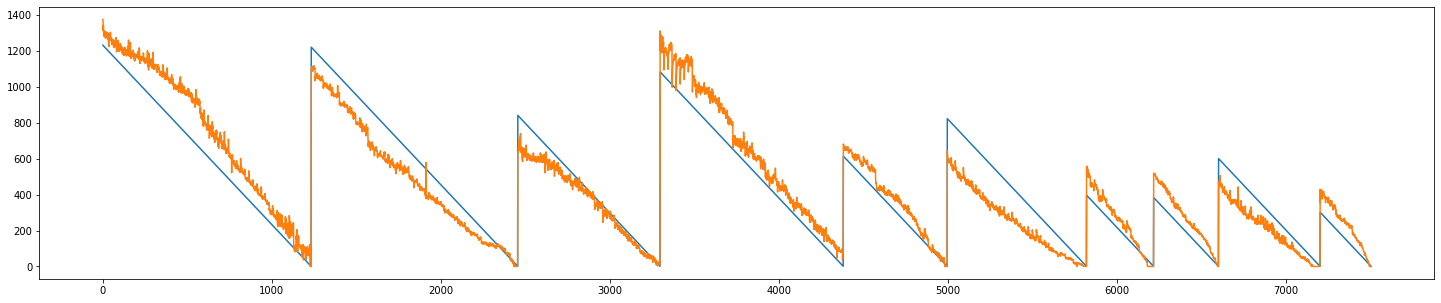

In [66]:
'''
    Testing model
'''

test_data1 = torch.tensor(test_discharge_feature1[:,None,:,::interval], dtype=torch.float32).to(device)
test_data2 = torch.tensor(test_discharge_feature2[:,None,:,::interval], dtype=torch.float32).to(device)
test_label_ = torch.tensor(test_label, dtype=torch.float32)
test_datset = TensorDataset(test_data1, test_data2, test_label_)
test_loader = DataLoader(test_datset, shuffle=False, batch_size=batch_size)

model.eval()

model.to(device)
test_pred_all = torch.tensor([]).to(device)
for step, (batch_x1,batch_x2, batch_y) in enumerate(test_loader):
    test_pred_temp = model(batch_x1, batch_x2).to(device)
    test_pred_all = torch.cat((test_pred_all, test_pred_temp), dim=0)

test_pred = test_pred_all.reshape(-1, 1)
test_rmse, test_mae, test_mape, test_r2 = test_accuracy_cal(test_pred.to(device), test_label_.to(device))
print(test_rmse, test_mae, test_mape, test_r2)

cycle = numpy.array(range(len(test_label)))
fig, ax = plt.subplots(figsize=(25, 5))
plt.plot(cycle, test_label)
plt.plot(cycle, test_pred.cpu().detach().numpy())
plt.show()

154.29419 112.58515 0.41401613 0.7777611


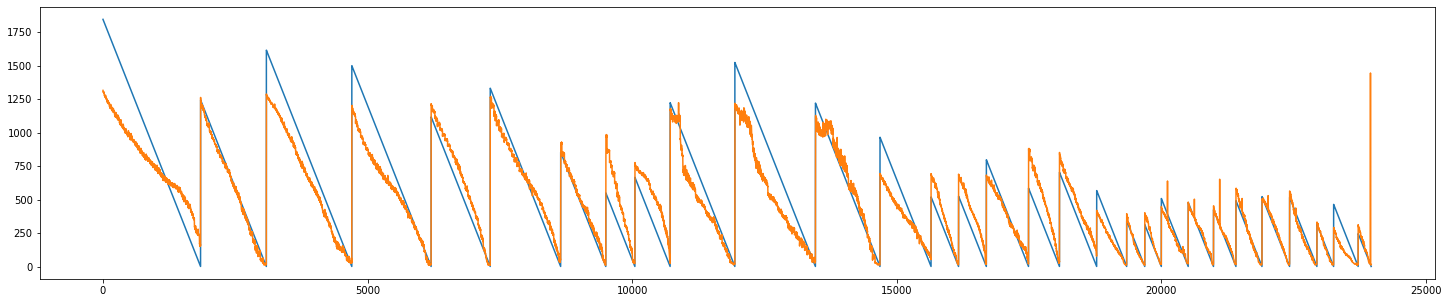

In [40]:
'''
    Testing model
'''

test_data1 = torch.tensor(test_discharge_feature1[:,None,:,::interval], dtype=torch.float32).to(device)
test_data2 = torch.tensor(test_discharge_feature2[:,None,:,::interval], dtype=torch.float32).to(device)
test_label_ = torch.tensor(test_label, dtype=torch.float32)
test_datset = TensorDataset(test_data1, test_data2, test_label_)
test_loader = DataLoader(test_datset, shuffle=False, batch_size=batch_size)

model.eval()
model.to(device)
test_pred_all = torch.tensor([]).to(device)
for step, (batch_x1,batch_x2, batch_y) in enumerate(test_loader):
    test_pred_temp = model(batch_x1, batch_x2).to(device)
    test_pred_all = torch.cat((test_pred_all, test_pred_temp), dim=0)

test_pred = test_pred_all.reshape(-1, 1)
test_rmse, test_mae, test_mape, test_r2 = test_accuracy_cal(test_pred.to(device), test_label_.to(device))
print(test_rmse, test_mae, test_mape, test_r2)

cycle = numpy.array(range(len(test_label)))
fig, ax = plt.subplots(figsize=(25, 5))
plt.plot(cycle, test_label)
plt.plot(cycle, test_pred.cpu().detach().numpy())
plt.show()

In [68]:
# Saving model

Saving_name = 'Cluster2_test0_cali_1'
torch.save(model, 'Trained_model/'+ Saving_name +'.pth')
loaded_model = torch.load('Trained_model/' + Saving_name+ '.pth')
model = loaded_model

In [71]:
# Saving results
import scipy.io as sio

data_all = {'test_rmse':test_rmse, 'test_mae':test_mae, 'test_mape':test_mape, 'test_r2':test_r2,
           'test_label':test_label, 'test_pred':test_pred.cpu().detach().numpy(), 'batch_list':batch_list, 'test_index':test_index}

sio.savemat('Results/'+ Saving_name +'.mat', data_all)